In [14]:
import numpy as np
import pandas as pd
import json

In [15]:
with open("cranfield/cran_docs.json",'r') as f:
    docs = json.load(f)
docs_df = pd.DataFrame(docs)

with open("cranfield/cran_qrels.json",'r') as f:
    rels = json.load(f)
rels_df = pd.DataFrame(rels)

with open("cranfield/cran_queries.json",'r') as f:
    queries = json.load(f)
queries_df = pd.DataFrame(queries)

In [16]:
docs_df.head()

,id,author,bibliography,body,title
0,1,"brenckman,m.","j. ae. scs. 25, 1958, 324.",experimental investigation of the aerodynamics...,experimental investigation of the aerodynamics...
1,2,ting-yili,"department of aeronautical engineering, rensse...",simple shear flow past a flat plate in an inco...,simple shear flow past a flat plate in an inco...
2,3,m. b. glauert,"department of mathematics, university of manch...",the boundary layer in simple shear flow past a...,the boundary layer in simple shear flow past a...
3,4,"yen,k.t.","j. ae. scs. 22, 1955, 728.",approximate solutions of the incompressible la...,approximate solutions of the incompressible la...
4,5,"wasserman,b.","j. ae. scs. 24, 1957, 924.",one-dimensional transient heat conduction into...,one-dimensional transient heat conduction into...


In [17]:
# preprocess corpus
from nltk.tokenize import sent_tokenize, TreebankWordTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [18]:
def sent_tokenizer(doc_body):
    '''
    doc_body: a string
    -------
    return: a list of sentences
    '''
    return sent_tokenize(doc_body)

def word_tokenizer(sent_list):
    '''
    sent_list: list of sentences
    -------
    return: a list of list of tokens
    '''
    tokenizer = TreebankWordTokenizer()
    res = []
    for sent in sent_list:
        tokenized_list = tokenizer.tokenize(sent)
        res.append(tokenized_list)
    return res


def stopword_removal(token_list):
    '''
    token_list: list of list of tokens
    -------
    return: list of list of tokens without stopwords 
    '''
    stopwords_set = set(stopwords.words("english"))
    res = []
    for sent in token_list:
        removed_list = [token for token in sent if token.lower() not in stopwords_set]
        res.append(removed_list)
    
    return res

def inflection_reduction(token_list):
    '''
    token_list: list of list of tokens
    -------
    return: list of list of tokens without stopwords 
    '''
    stemmer = PorterStemmer()
    res = []
    for sent in token_list:
        stemmed_list = [stemmer.stem(token) for token in sent]
        res.append(stemmed_list)
    
    return res

def rejoin(sent_list):
    '''
    token_list: list of list of tokens
    -------
    return: a str 
    '''
    res = ""
    for sent in sent_list:
        res += " ".join(sent)
    return res

In [19]:
# doc = docs_df['body'][0]
# sent = sent_tokenizer(doc)
# tokenized = word_tokenizer(sent)
# stemmed = inflection_reduction(tokenized)
# stopword_removed = stopword_removal(stemmed)
# preprocessed_doc = rejoin(stopword_removed)


In [20]:
corpus = []
for doc in docs_df['body']:
    sent = sent_tokenizer(doc)
    tokenized = word_tokenizer(sent)
    stemmed = inflection_reduction(tokenized)
    stopword_removed = stopword_removal(stemmed)
    preprocessed_doc = rejoin(stopword_removed)
    corpus.append(preprocessed_doc)

In [21]:
from sentence_transformers import SentenceTransformer

In [22]:
encoder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

c:\Users\kumar\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [26]:
len(corpus)

1400

# Indexing the corpus

## Encoding

In [27]:
index = encoder.encode(corpus)
index.shape

(1400, 384)

* Encoding time:  2m 54.6 sec
* Encoding dimension: 384

## Clustering

In [47]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [50]:
ks = [5,10,15,20,25,30,40,50,100,150,200] 

In [51]:
inertia = []
silhouette_scores = []

In [52]:
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(index)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(index, kmeans.labels_)
    silhouette_scores.append(score)

In [53]:
import matplotlib.pyplot as plt

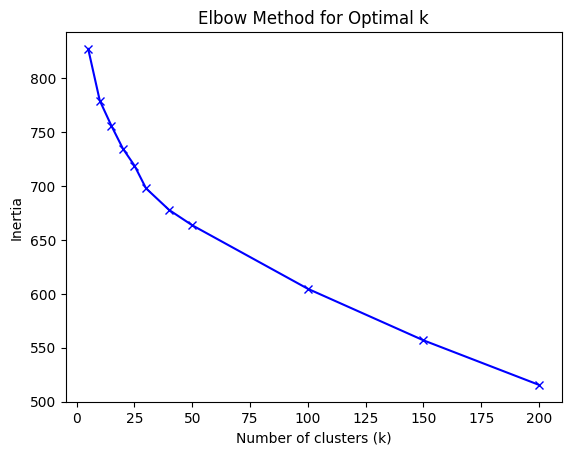

In [54]:
# Plot the results
plt.plot(ks, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

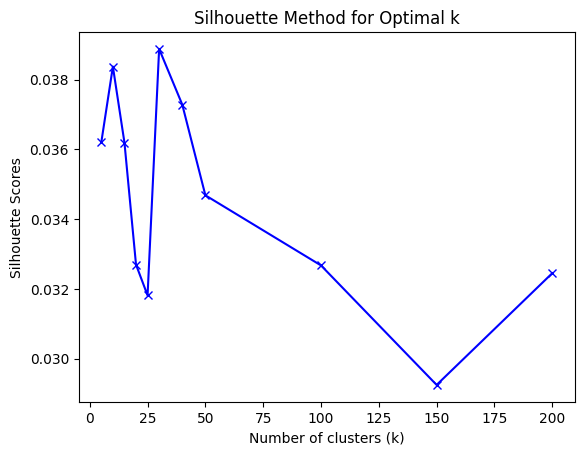

In [55]:
# Plot the results
plt.plot(ks, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette Method for Optimal k')
plt.show()

In [56]:
## K = 30

In [57]:
kmeans = KMeans(n_clusters=30)
kmeans.fit(index)

KMeans(n_clusters=30)

* Clustering time: 0.3 sec

In [63]:
cluster_dict = {i:[] for i in range(30)}
for i,label in enumerate(kmeans.labels_):
    if cluster_dict[label]: 
        cluster_dict[label].append(i)
    else:
        cluster_dict[label] = [i]

# Retrieval and Ranking

In [64]:
doc_IDs_ordered = []
queries_flattened = []

In [66]:
queries_df

,query number,query
0,1,what similarity laws must be obeyed when const...
1,2,what are the structural and aeroelastic proble...
2,3,what problems of heat conduction in composite ...
3,4,can a criterion be developed to show empirical...
4,5,what chemical kinetic system is applicable to ...
...,...,...
220,221,papers applicable to this problem (calculation...
221,222,has anyone investigated the shear buckling of ...
222,223,papers on shear buckling of unstiffened rectan...
223,224,"in practice, how close to reality are the assu..."


In [67]:
queries_flattened = []
for q in queries_df['query']:
    sent = sent_tokenizer(q)
    tokenized = word_tokenizer(sent)
    stemmed = inflection_reduction(tokenized)
    stopword_removed = stopword_removal(stemmed)
    preprocessed_q = rejoin(stopword_removed)
    queries_flattened.append(preprocessed_q)

In [70]:
query_index = encoder.encode(queries_flattened)
query_index.shape, type(query_index)
# query_index = np.array(query_index, dtype=np.float64)

((225, 384), numpy.ndarray)

In [71]:
from sklearn.metrics.pairwise import cosine_similarity

In [75]:
docIDs = docs_df['id']

In [89]:
index[cluster_dict[8]].shape

(18, 384)

In [106]:
center = kmeans.predict(query_index[0].reshape(1,-1))
center = center[0]
# print(center)
sims = cosine_similarity(query_index[0].reshape(1,-1),index[cluster_dict[center]])[0]
top_ids = [i for sim,i in sorted(list(zip(sims,cluster_dict[center])),key=lambda x:x[0],reverse=True)]
# top_doc_ids = [docIDs[doc_id] for doc_id in top_ids]
# doc_IDs_ordered.append(top_doc_ids)
top_ids

8


[485,
 12,
 859,
 496,
 194,
 876,
 1176,
 29,
 65,
 836,
 94,
 30,
 858,
 869,
 728,
 1145,
 857,
 765]

In [107]:
for query in query_index:
    # kmeans.cluster_centers_ = kmeans.cluster_centers_.astype(float)
    center = kmeans.predict(query.reshape(1,-1))
    center = center[0]
    sims = cosine_similarity(query.reshape(1,-1),index[cluster_dict[center]])[0]
    top_ids = [i for sim,i in sorted(list(zip(sims,cluster_dict[center])),key=lambda x:x[0],reverse=True)]
    top_doc_ids = [docIDs[doc_id] for doc_id in top_ids]
    doc_IDs_ordered.append(top_doc_ids)